In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
    #    print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**1. Importing Necessary Libraries**

In [63]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import os
import itertools
from glob import glob

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

**2. Reading and exploring data**

In [3]:
df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df

lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]

In [4]:
df['sex'].value_counts()

sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

In [5]:
df['localization'].value_counts()

localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64

In [6]:
df['dx_type'].value_counts()

dx_type
histo        5340
follow_up    3704
consensus     902
confocal       69
Name: count, dtype: int64

In [7]:
df['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [8]:
lesion_type = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'}

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


**3. Directory fixing**

In [10]:
base_dir = '../input/skin-cancer-mnist-ham10000'

In [11]:
# # Merge images from both folders into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

**4. Output variable**

In [12]:
df['cell_type_idx'] = pd.Categorical(df['dx']).codes
df

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

       cell_type_idx  
0                  2  
1                  2  
2                  2  
3                  2  
4                  2  
...              ...  
10010              0  
10011              0  
10012              0  
10013              0  
10014              4  

[10015 rows x 8 columns]

In [13]:
df['cell_type_idx'].value_counts()

cell_type_idx
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64

**5. Missing Values**

In [14]:
df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
cell_type_idx     0
dtype: int64

In [15]:
df['age'].fillna((df['age'].mean()), inplace=True)

/tmp/ipykernel_30/1123070014.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna((df['age'].mean()), inplace=True)


In [16]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
cell_type_idx    0
dtype: int64

**6. DataViz (EDA)**

*Plotting the distribution of population based on sex*

<Axes: xlabel='sex', ylabel='count'>

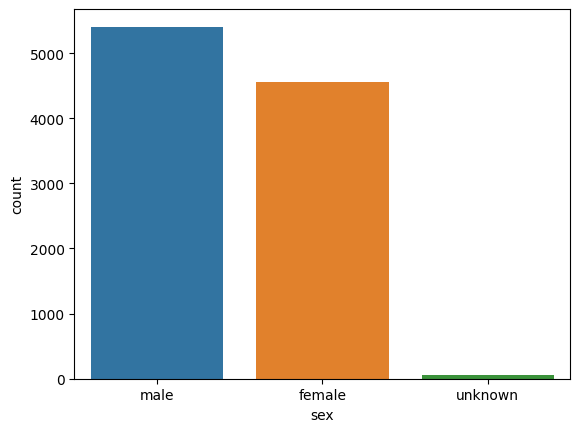

In [17]:
sns.countplot(x='sex',data=df)

*Plotting the cell types of affected patients*

<Axes: xlabel='dx', ylabel='count'>

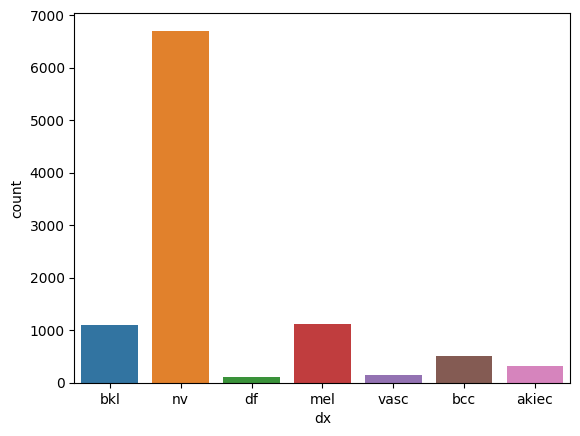

In [18]:
sns.countplot(x='dx',data=df)

In [19]:
df['cell_type'] = df['dx'].map(lesion_type.get)

In [20]:
df

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

       cell_type_idx                       cell_type  
0                  2  Benign keratosis-like lesions   
1                  2  Benign keratosis-like lesions   
2                  2  Benign keratosis-like lesions   
3                  2  Benign keratosis-like lesions   
4                  2  Benign keratosis-like lesions   
...              ...                             ...  
10010              0               Actinic keratoses  
10011              0               Actinic keratoses  
10012              0               Actinic keratoses  
10013              0               Actinic keratoses  
10014              4                        Melanoma  

[10015 rows x 9 columns]

<Axes: xlabel='cell_type', ylabel='count'>

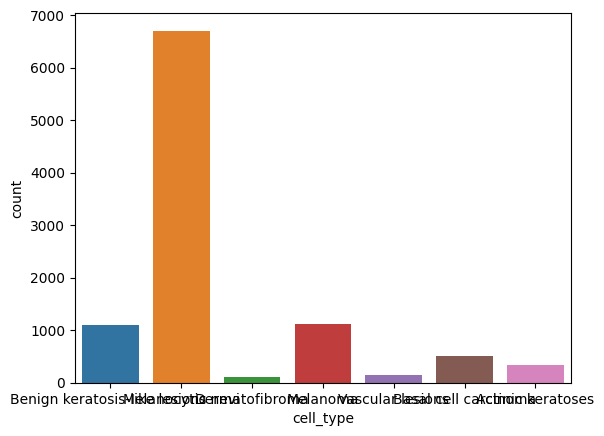

In [21]:
sns.countplot(x='cell_type',data=df)

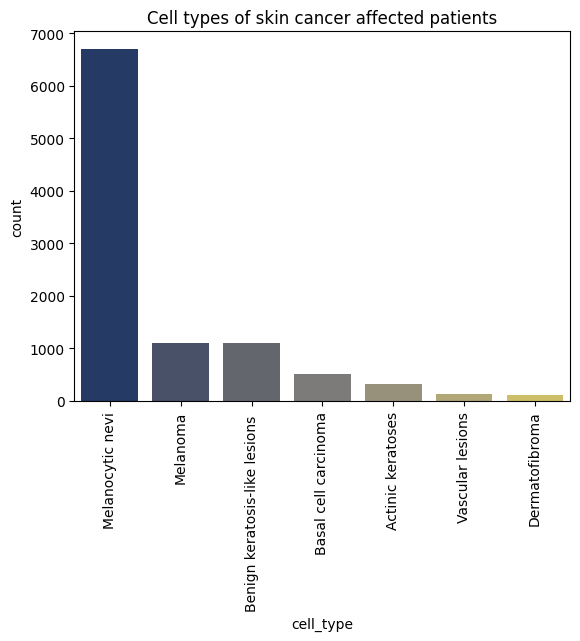

In [22]:
ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'cividis')
plt.title('Cell types of skin cancer affected patients')
plt.xticks(rotation=90)
plt.show()

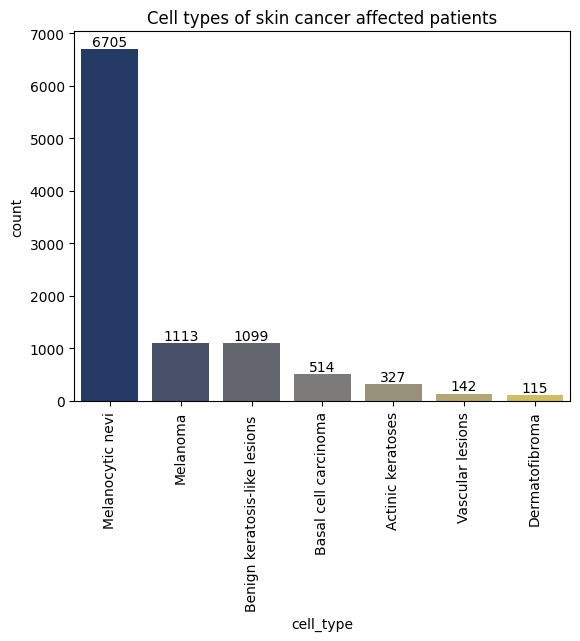

In [23]:
ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'cividis')

for container in ax.containers:
    ax.bar_label(container)
    
plt.title('Cell types of skin cancer affected patients')
plt.xticks(rotation=90)
plt.show()

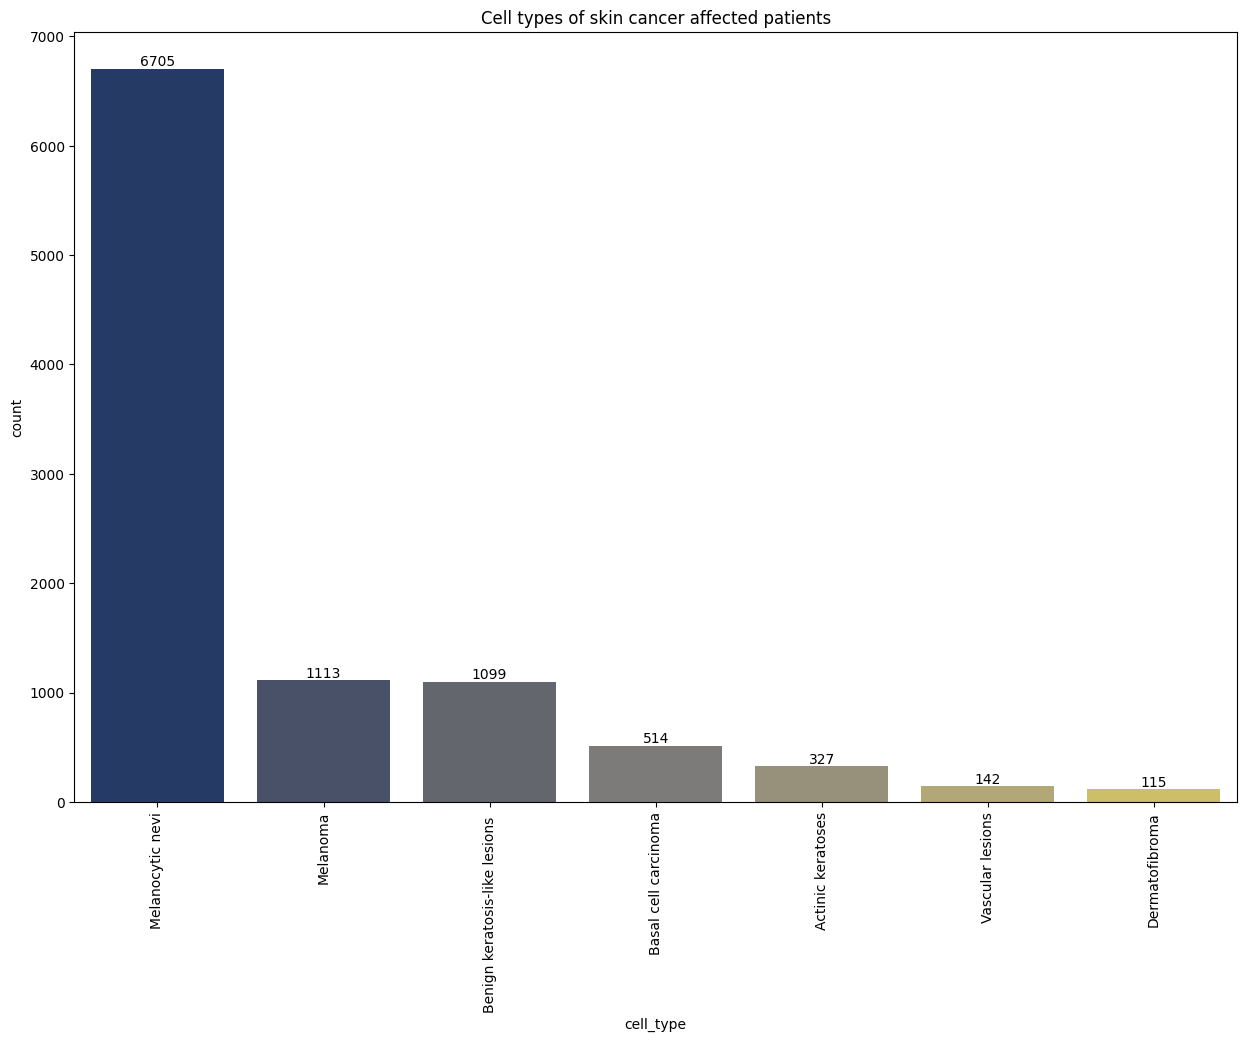

In [24]:
plt.subplots(figsize=(15,10))
ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'cividis')

for container in ax.containers:
    ax.bar_label(container)
    
plt.title('Cell types of skin cancer affected patients')
plt.xticks(rotation=90)
plt.show()

*Plotting the distribution of localization field*

<Axes: xlabel='localization'>

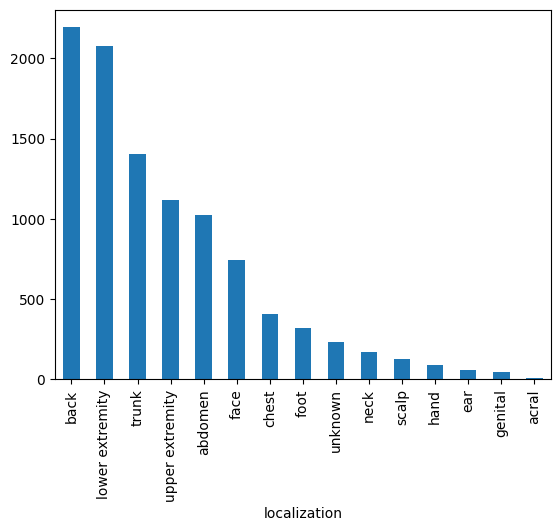

In [25]:
# plotting using Pandas library
df['localization'].value_counts().plot(kind='bar')

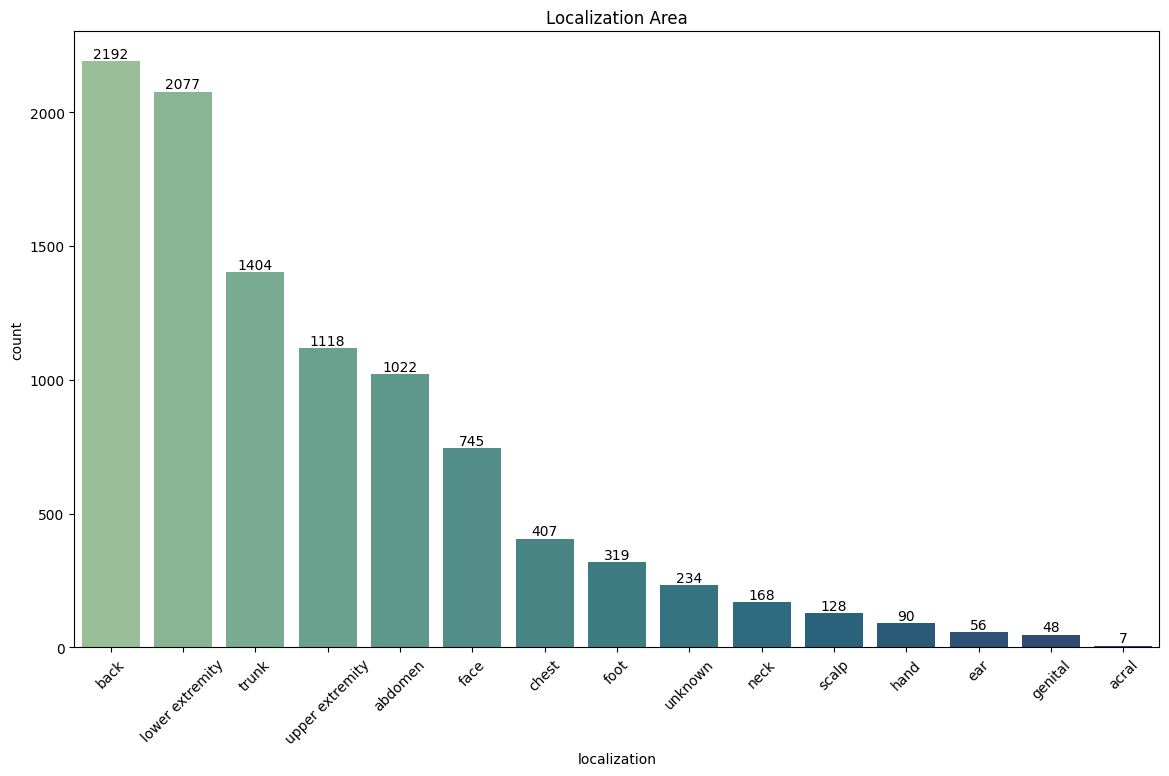

In [26]:
plt.subplots(figsize=(14,8))
ax = sns.countplot(x='localization',data=df, order = df['localization'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area')
plt.xticks(rotation=45)
plt.show()

*Plotting the Age distribution of patients*

<Axes: >

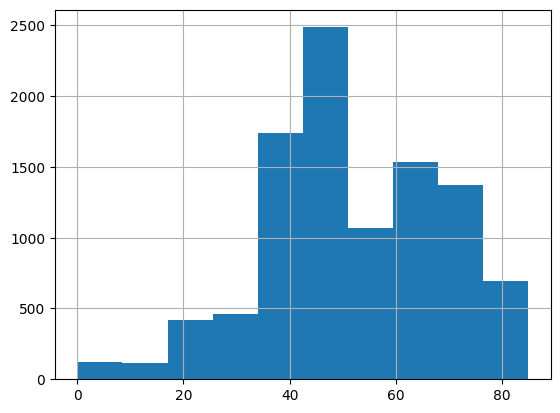

In [27]:
df['age'].hist()

<Axes: >

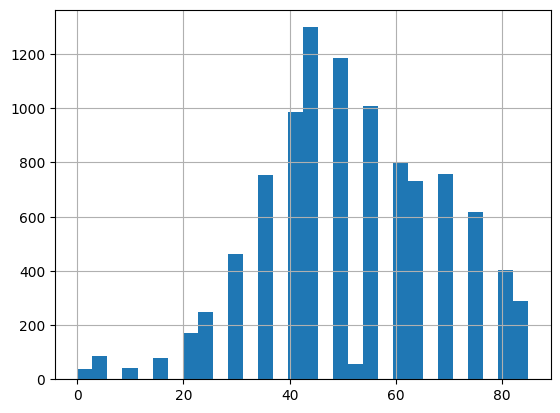

In [28]:
df['age'].hist(bins=30)

<Axes: >

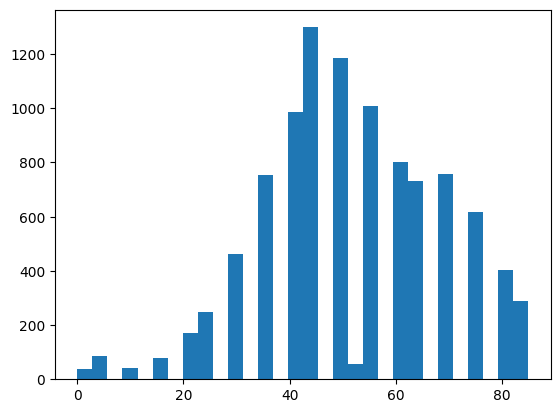

In [29]:
df['age'].hist(bins=30, grid=False)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='age', ylabel='Count'>

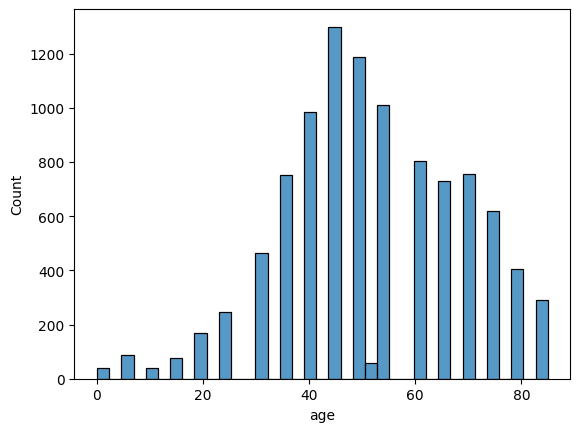

In [30]:
sns.histplot(data=df, x='age')

*Plotting gender vs affected cell type*

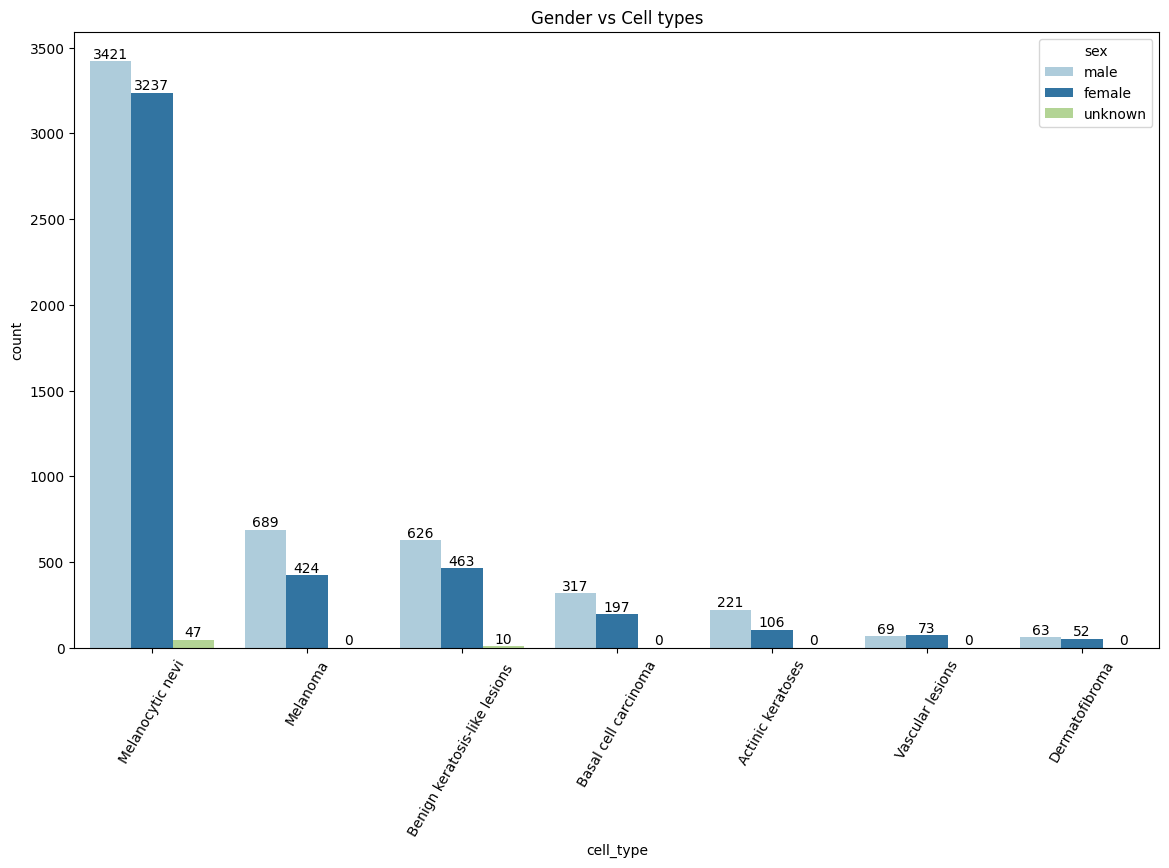

In [31]:
plt.subplots(figsize=(14,8))
ax = sns.countplot(x='cell_type',hue='sex', data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Gender vs Cell types')
plt.xticks(rotation=60)
plt.show()

*Gender vs localization*

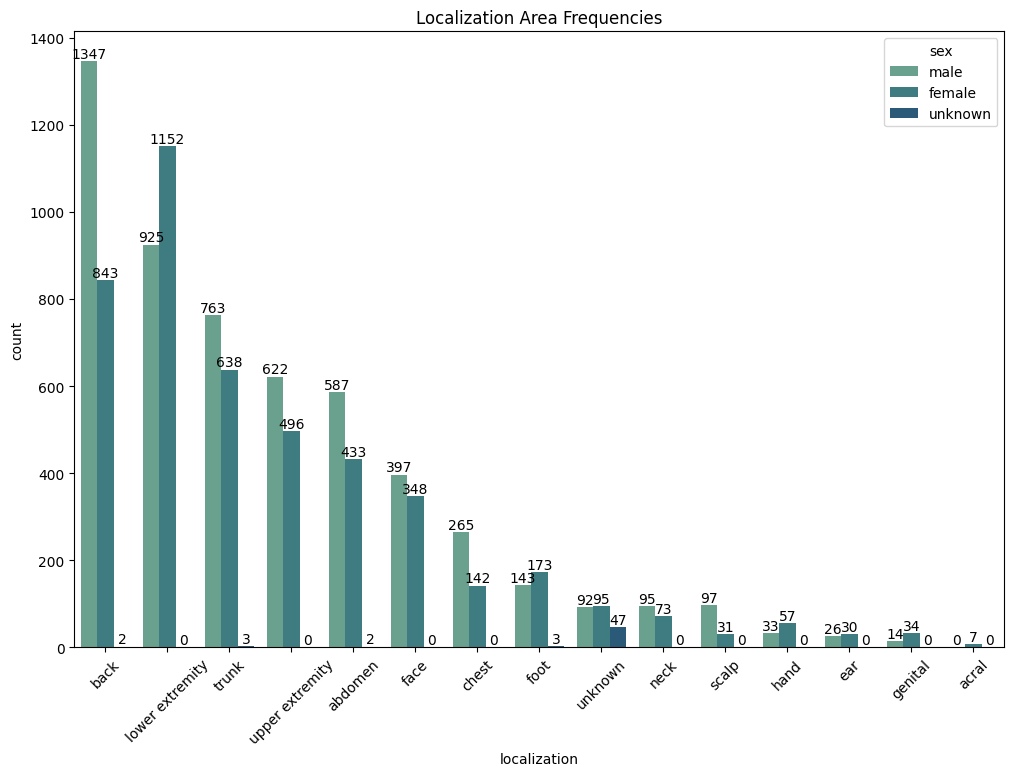

In [32]:
plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization',data=df, hue = 'sex', order = df['localization'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

**7. Visualizing Cell images**

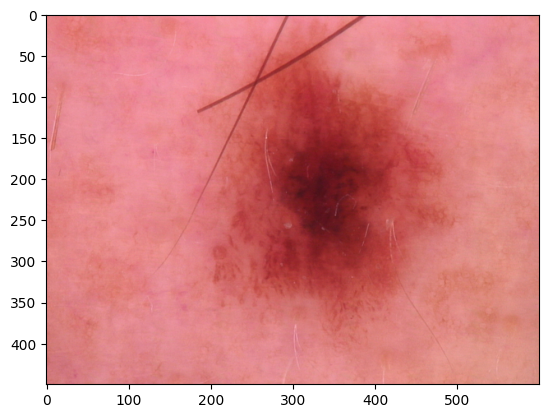

In [33]:
path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024306.jpg'
img = tf.keras.preprocessing.image.load_img(path)
plt.imshow(img)

In [34]:
img.size

(600, 450)

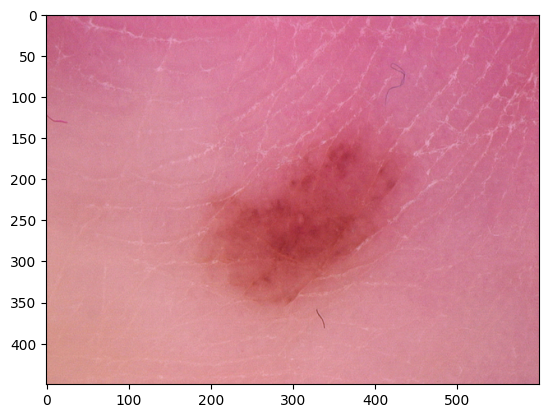

In [35]:
path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024322.jpg'
img = tf.keras.preprocessing.image.load_img(path)
plt.imshow(img)

In [36]:
img.size

(600, 450)

*Visualize images from all categories*

In [37]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,100))))

In [38]:
df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

   cell_type_idx                       cell_type  \
0              2  Benign keratosis-like lesions    
1              2  Benign keratosis-like lesions    
2              2  Benign keratosis-like lesions    
3              2  Benign keratosis-like lesions    
4              2  Benign keratosis-like lesions    

                                                path  \
0  ../input/skin-cancer-mnist-ham10000/ham10000_i...   
1  ../input/skin-cancer-mnist-ham10000/ham10000_i...   
2  ../input/skin-cancer-mnist-ham10000/ham10000_i...   
3  ../input/skin-cancer-mnist-ham10000/ham10000_i...   
4  ../input/skin-cancer-mnist-ham10000/ham10000_i...   

                                               image  
0  [[[190, 153, 195], [192, 155, 197], [191, 153,...  
1  [[[24, 13, 22], [24, 14, 24], [25, 14, 28], [3...  
2  [[[186, 128, 137], [190, 134, 148], [194, 137,...  
3  [[[24, 11, 17], [25, 12, 22], [36, 21, 30], [5...  
4  [[[132, 89, 112], [146, 101, 124], [158, 114, ...

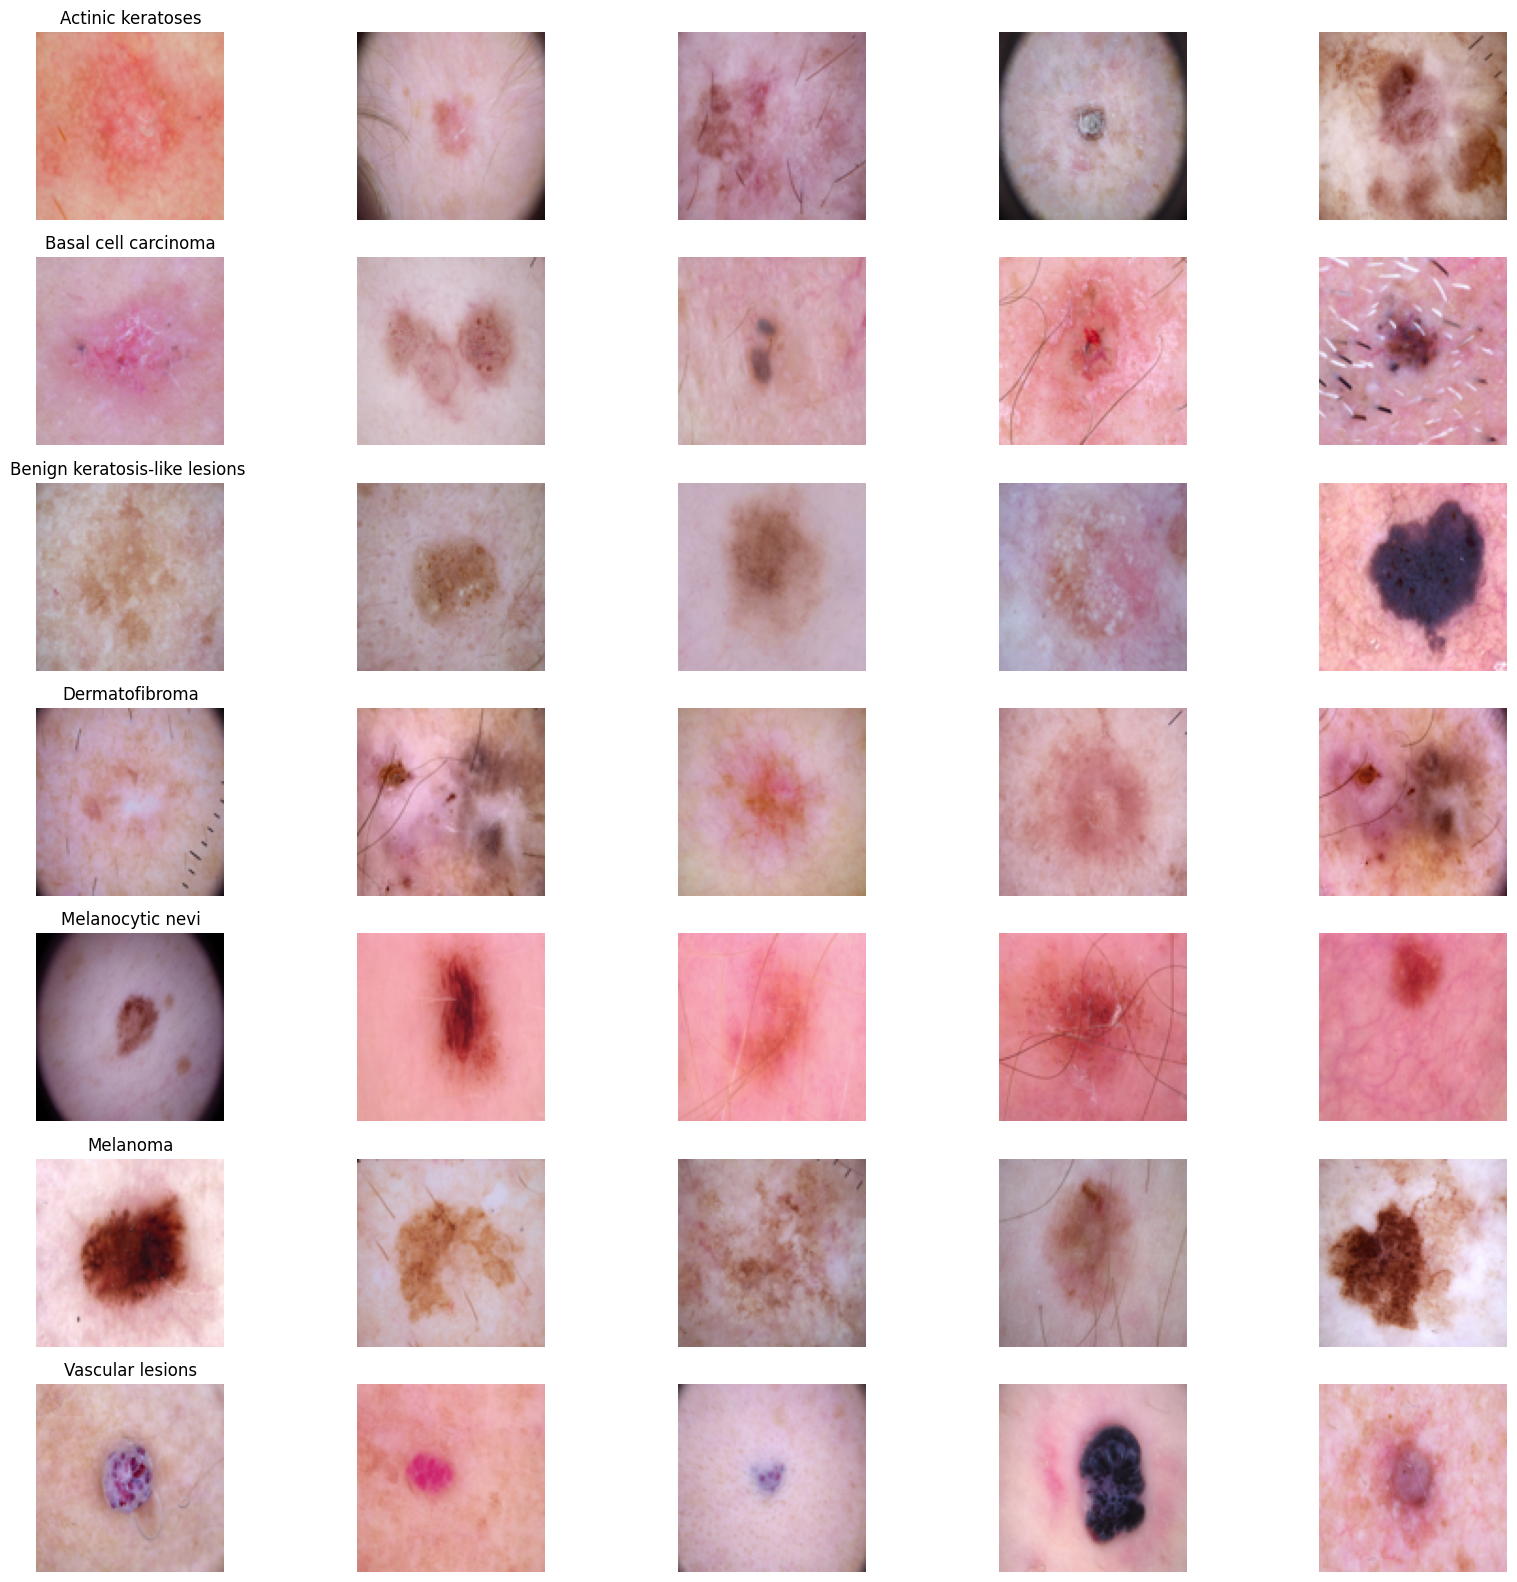

In [57]:
num_cat = 7   # no of categories
num_samp = 5  # no of samples to show from each category
r= 20         # random_state - change to get different images

fig, m_axs = plt.subplots(num_cat, num_samp, figsize = (20,20))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(num_samp, random_state=r).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [58]:
fig.savefig('category_samples.png', dpi=600)

**8. Preparing data for modelling**

In [40]:
y= df['cell_type_idx']
y

0        2
1        2
2        2
3        2
4        2
        ..
10010    0
10011    0
10012    0
10013    0
10014    4
Name: cell_type_idx, Length: 10015, dtype: int8

In [41]:
x= df.drop(columns=['cell_type_idx'],axis=1)

In [42]:
x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(x, y, test_size=0.20,random_state=10)

In [43]:
x_train_all['image'].iloc[0]

array([[[148,  93, 106],
        [149,  92, 105],
        [155, 105, 115],
        ...,
        [182, 118, 124],
        [181, 121, 126],
        [179, 124, 129]],

       [[147,  90, 107],
        [149,  93, 108],
        [155, 104, 115],
        ...,
        [183, 121, 126],
        [181, 121, 125],
        [179, 121, 126]],

       [[149,  94, 112],
        [152,  97, 117],
        [151, 101, 113],
        ...,
        [185, 125, 129],
        [181, 122, 126],
        [179, 119, 124]],

       ...,

       [[146,  91,  97],
        [146,  93,  99],
        [142,  89,  99],
        ...,
        [180, 131, 133],
        [180, 132, 133],
        [176, 129, 129]],

       [[145,  92,  97],
        [142,  89,  96],
        [141,  89,  99],
        ...,
        [178, 129, 132],
        [179, 130, 133],
        [177, 130, 131]],

       [[144,  88,  95],
        [138,  84,  90],
        [140,  84,  92],
        ...,
        [176, 128, 131],
        [176, 126, 129],
        [175, 128, 129]]

In [44]:
x_train_all['image'].iloc[0].shape

(100, 100, 3)

*Normalization*

In [45]:
x_train = np.asarray(x_train_all['image'].tolist())
x_test = np.asarray(x_test_all['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

*Output Variable - One hot encoding*

In [46]:
y_train = tf.keras.utils.to_categorical(y_train_all, num_classes = 7)
y_test = tf.keras.utils.to_categorical(y_test_all, num_classes = 7)

In [47]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

*Validation Set*

In [48]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 20)

*Reshaping images into 3 dimension*

In [49]:
x_train = x_train.reshape(x_train.shape[0], *(100, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 100, 3))

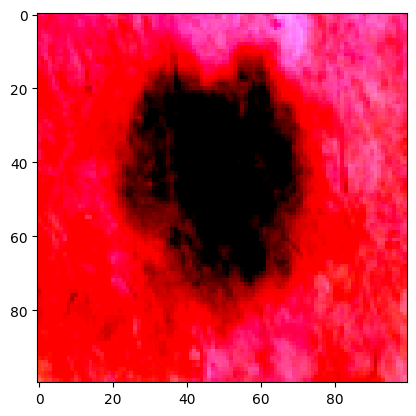

In [50]:
image_array = x_train[10]
plt.imshow(image_array)

In [51]:
print(np.sum(np.isnan(x_train)))
print(np.sum(np.isnan(y_train)))
print(np.sum(np.isnan(x_test)))
print(np.sum(np.isnan(y_test)))
print(np.sum(np.isnan(x_validate)))
print(np.sum(np.isnan(y_validate)))

0
0
0
0
0
0


**9. CNN architecture**

In [52]:
model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(32, (11, 11), padding= 'same', activation="relu",input_shape=(100, 100, 3)),
    tf.keras.layers.Conv2D(64, (7,7), padding= 'same', activation="relu"),

    tf.keras.layers.MaxPooling2D((2, 2), padding= 'same',  strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (3,3), padding= 'same',  activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), padding= 'same',  strides=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (3,3), padding= 'same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), padding= 'same',  strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(256, (3,3), padding= 'same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), padding= 'same',  strides=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(512, (3,3), padding= 'valid', activation="relu"),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(600, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation="softmax")
]
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 600)            │     7,680,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 600)            │         2,400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         4,207 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,496,807 (36.23 MB)

 Trainable params: 9,495,223 (36.22 MB)

 Non-trainable params: 1,584 (6.19 KB)

**10. Callback**

In [54]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

**11. Training**

In [55]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy', # for one-hot encoded y
              metrics=['accuracy'])

In [56]:
history = model.fit(x_train, y_train,
                    epochs=50,
                    validation_data= (x_validate,y_validate),
                    batch_size=64,
                    callbacks=early_stop)

Epoch 1/50


I0000 00:00:1727870648.758755     100 service.cc:145] XLA service 0x7993d80156c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727870648.758848     100 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727870648.758855     100 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-10-02 12:04:17.905441: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,100,100]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,100,100]{3,2,1,0}, f32[64,32,7,7]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-10-02 12:04:18.037443: E external/local_xla/xl

113/113 ━━━━━━━━━━━━━━━━━━━━ 53s 289ms/step - accuracy: 0.5276 - loss: 1.5829 - val_accuracy: 0.6808 - val_loss: 1.2462
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 0.6895 - loss: 0.8649 - val_accuracy: 0.6471 - val_loss: 1.2427
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.6946 - loss: 0.8407 - val_accuracy: 0.7045 - val_loss: 0.8261
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.7252 - loss: 0.7408 - val_accuracy: 0.6160 - val_loss: 1.0441
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 0.7359 - loss: 0.7208 - val_accuracy: 0.7132 - val_loss: 0.8714
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.7424 - loss: 0.7010 - val_accuracy: 0.6135 - val_loss: 0.9071
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 0.7706 - loss: 0.6443 - val_accuracy: 0.7020 - val_loss: 0.8122
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 0.7510 - loss: 0.6592 - val

**12. Model Figure**

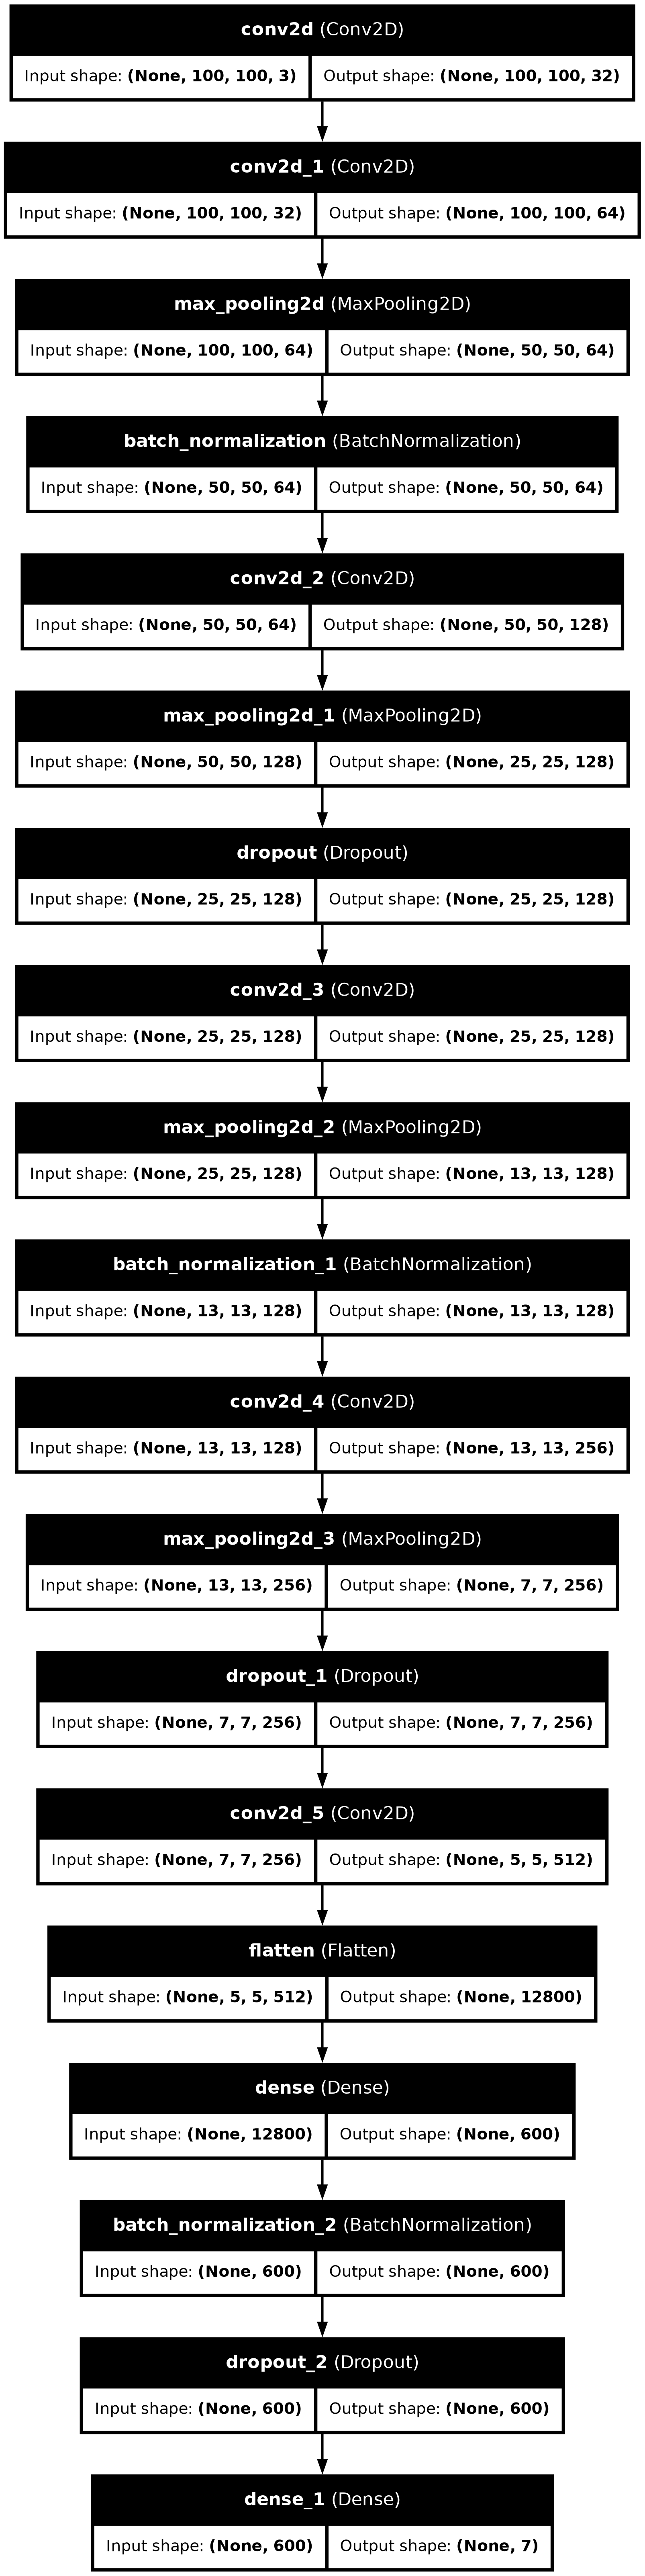

In [64]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

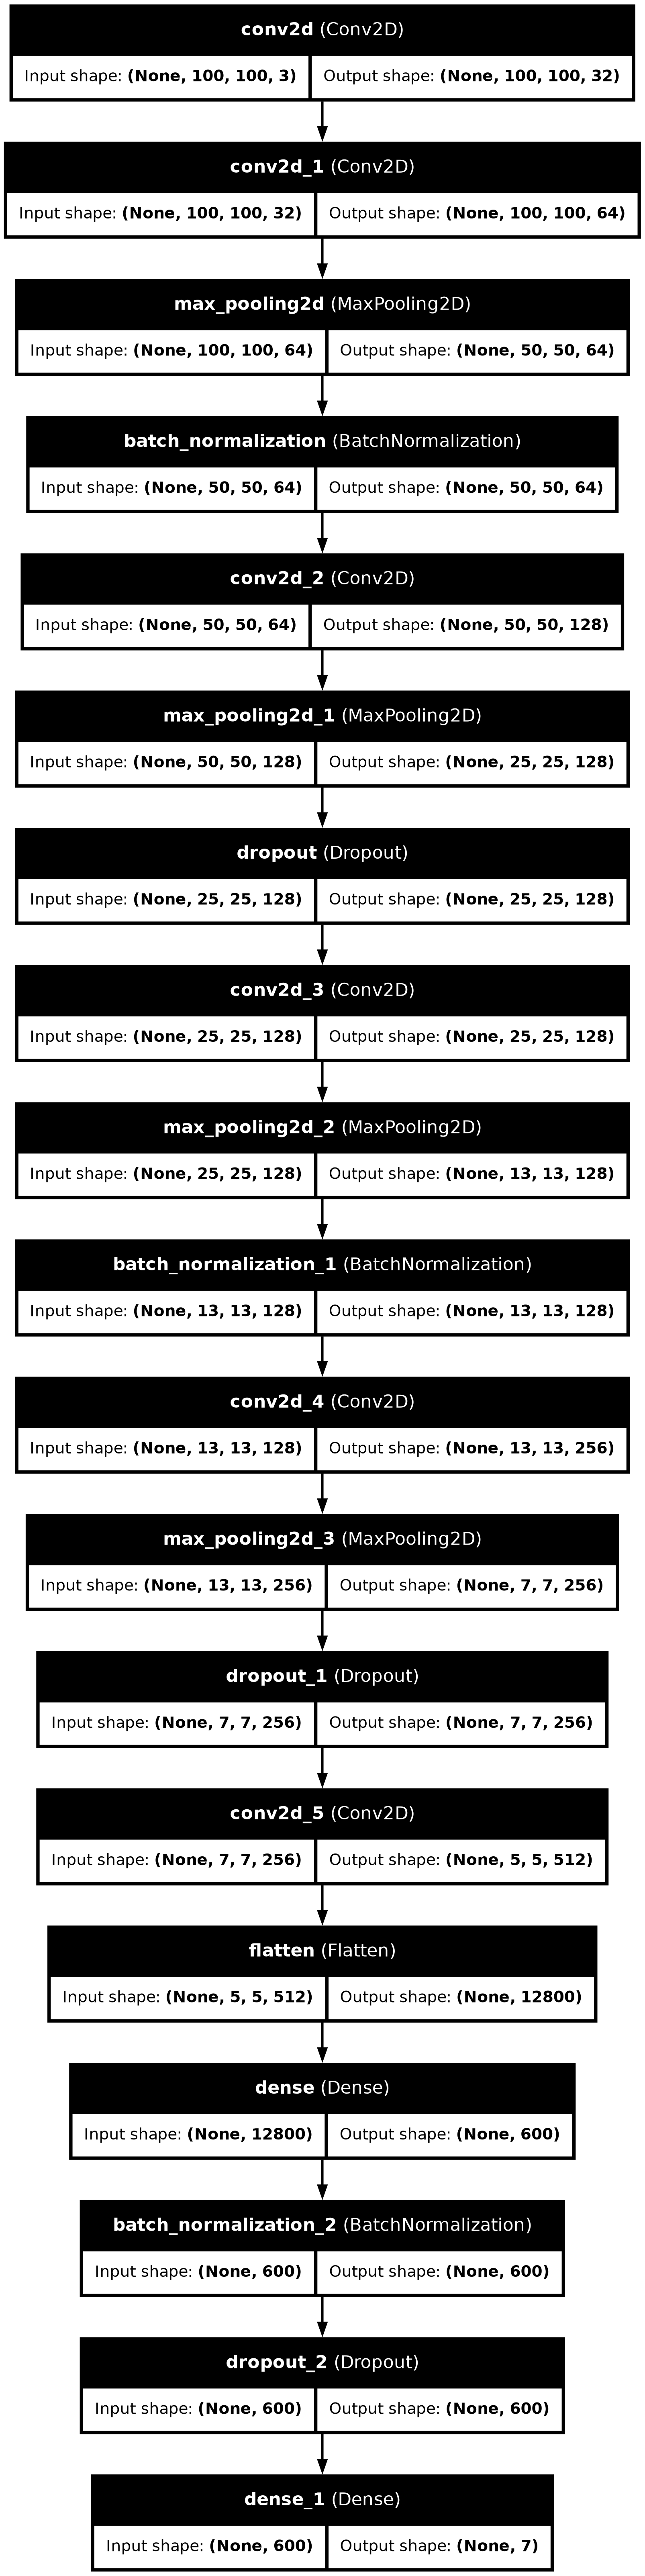

In [66]:
plot_model(model, to_file='/kaggle/working/model_plot.png', show_shapes=True, show_layer_names=True)

In [72]:
fig.savefig('model_arch.png', dpi=600)

**13. Results**

In [65]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7333 - loss: 0.9607
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7382 - loss: 1.0200
Validation: accuracy = 0.746883  ;  loss_v = 0.996133
Test: accuracy = 0.731902  ;  loss = 0.983981


**14. Plotting training and validation curve**

In [68]:
df = pd.DataFrame(history.history)
df.head()

accuracy      loss  val_accuracy  val_loss
0  0.618447  1.184890      0.680798  1.246180
1  0.688349  0.853924      0.647132  1.242713
2  0.706103  0.811230      0.704489  0.826095
3  0.724411  0.751291      0.615960  1.044066
4  0.732732  0.729449      0.713217  0.871363

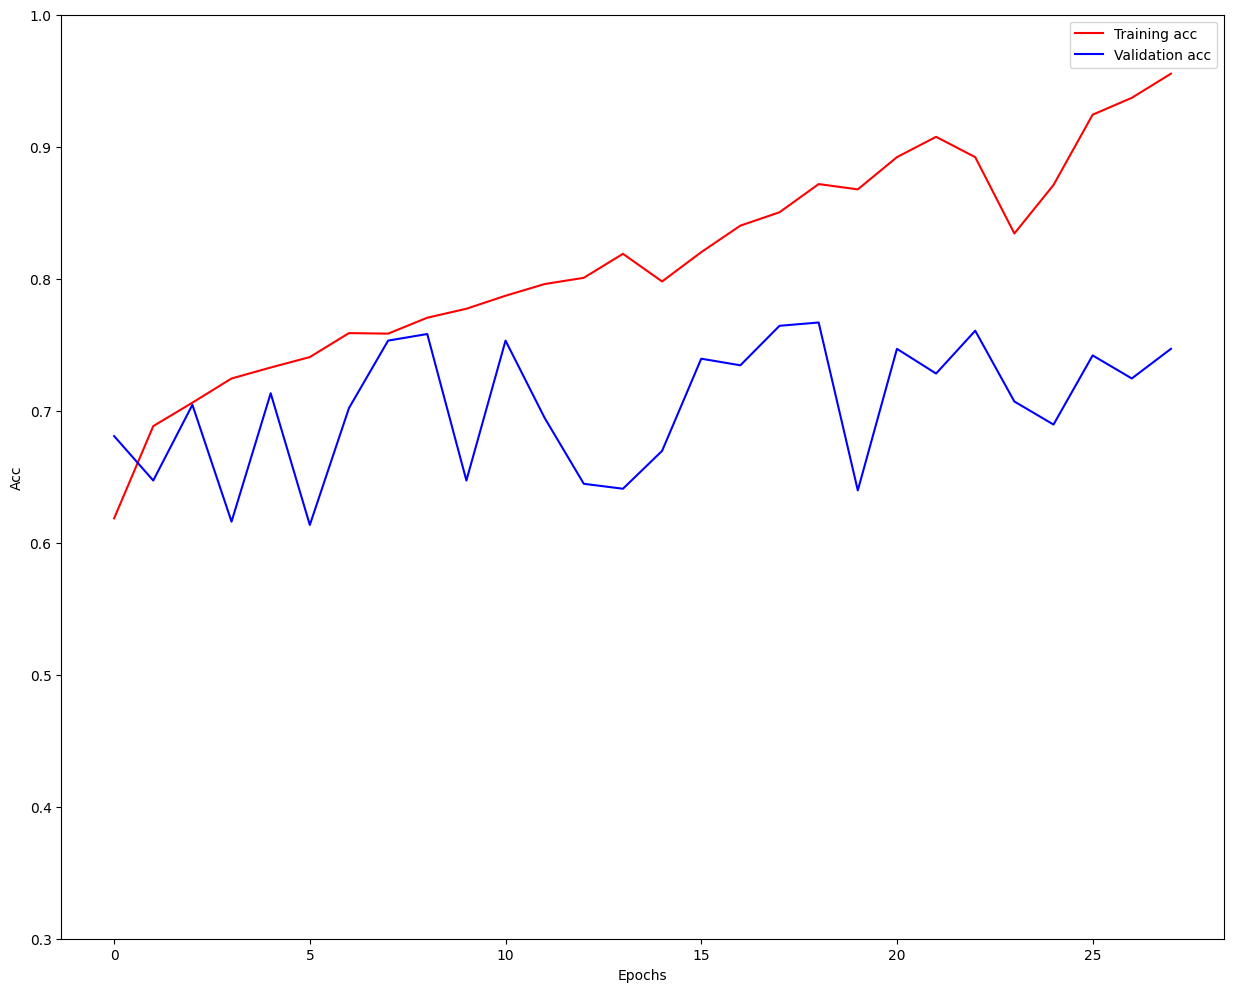

In [69]:
train_acc = df["accuracy"]
val_acc = df["val_accuracy"]
epochs = range(len(train_acc))

plt.figure(figsize=(15,12))
plt.ylim([0.3, 1])
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

So, the data is gradually overfitting. We need to add additional callback parameters.

**15. Confusion Matrix**

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


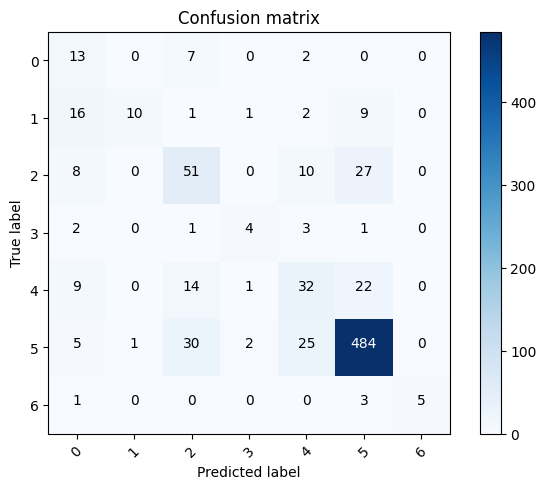

In [70]:
 def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)


# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


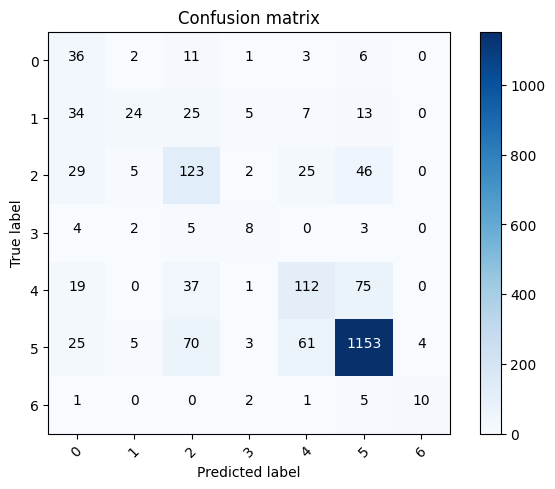

In [71]:
# Predict the values from the test dataset
Y_pred = model.predict(x_test) 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

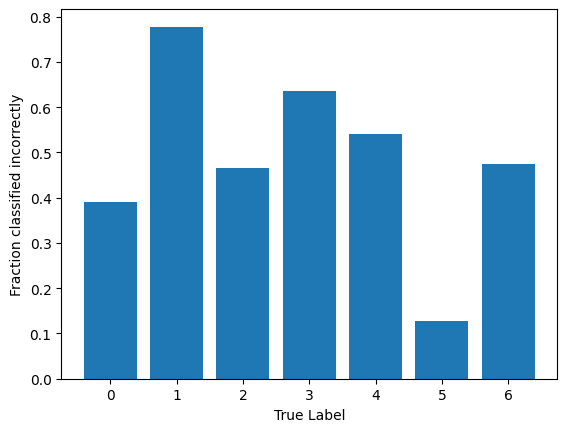

In [73]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

**16. Save model Weights**

In [74]:
model.save("skin_model_ham10000.h5")

To perform - 
1. Data augmentation
2. Transfer learning
3. XAI with LIME, SHAP